# Run

In [1]:
# plotting a prameters
scale_factor = 1.5

labels = 16 * scale_factor
ticks = 10 * scale_factor
# ticks = 10 * scale_factor
legends = 12 * scale_factor
text = 14 * scale_factor
titles = 22 * scale_factor
lw = 3 * scale_factor
ps = 200 * scale_factor
cmap = 'magma'

colors = ['firebrick', 'steelblue', 'darkorange', 'darkviolet', 'cyan', 'magenta', 'darkgreen', 'deeppink']
markers = ['x', 'o', '+', '>', '*', 'D', '4']
linestyles = ['-', '--', ':', '-.']

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import PIL

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, progress
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

from sklearn.model_selection import train_test_split

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split

import torchmetrics

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T

In [3]:
### Set seed for reproducibility
np.random.seed(123)
random.seed(123)
torch.manual_seed(123)

## Load data

In [4]:
## Define loading transformations
transforms = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

### Download fashion MNIST
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True,
    transform=transforms)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True,
    transform=transforms)

### make data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
xy = int(train_dataset.train_data.size(1) * train_dataset.train_data.size(2))

/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Define models

### Individual models

In [19]:
class MLP(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 784,
        output_dim: int = 1,
        lr: float = 1e-4,
        weight_decay: float = 1e-8,
        adam_eps: float = 1e-7,
        weight_init: str = "xavier",
        num_mlp_layers: int = 5,
        mlp_layer_dim: int = 128,
        activation: str = "gelu",
        leaky_relu_frac: float = 0.2,
        dropout: float = 0.2,
        loss = nn.BCELoss(),
        feature_factor: float = 2.,
        final_activation = nn.Sigmoid(),
    ) -> None:
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.lr = lr
        self.weight_decay = weight_decay
        self.adam_eps = adam_eps
        self.weight_init = weight_init
        self.num_mlp_layers = num_mlp_layers
        self.mlp_layer_dim = mlp_layer_dim
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.output_layers = nn.ModuleList()
        self.activation_layers = nn.ModuleList()

        for _i in range(num_mlp_layers):
            if _i > 0:
                # import pdb; pdb.set_trace()
                self.layers.append(nn.Linear(self.layers[-1].out_features, 
                                             int(feature_factor*self.layers[-1].out_features)))
            else:
                self.layers.append(nn.Linear(self.input_dim, mlp_layer_dim))

            self.activation_layers.append(
                nn.GELU() if activation == "gelu" else nn.LeakyReLU(leaky_relu_frac, inplace=True)
            )
            self.activation_layers.append(nn.Dropout(dropout))

        self.output_layers.append(nn.Linear(self.layers[-1].out_features, self.output_dim))
        self.output_layers.append(final_activation)

        self.init_weights()  # Initialize the weights

        self.loss = loss

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if self.weight_init == "xavier":
                    nn.init.xavier_uniform_(layer.weight)  # Apply Xavier initialization
                elif self.weight_init == "kaiming":
                    nn.init.kaiming_uniform_(layer.weight)  # Apply Kaiming initialization
                elif self.weight_init == "orthogonal":
                    nn.init.orthogonal_(layer.weight)  # Apply orthogonal initialization

                nn.init.constant_(layer.bias, 0.0)

    def forward(self, z):
        for i, layer in enumerate(self.layers):
            z = layer(z)
            z = self.activation_layers[i](z)
        for layer in self.output_layers:
            z = layer(z)
        return z

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, eps=self.adam_eps, weight_decay=self.weight_decay
        )
        return self.optimizer


class Generator(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 64,
        output_dim: int = 784,
        lr: float = 1e-4,
        weight_decay: float = 1e-8,
        adam_eps: float = 1e-7,
        weight_init: str = "xavier",
        num_mlp_layers: int = 3,
        mlp_layer_dim: int = 128,
        activation: str = "gelu",
        leaky_relu_frac: float = 0.2,
        dropout: float = 0.2,
        loss = nn.BCELoss(),
        feature_factor: float = 2.,
        final_activation = nn.Tanh(),
    ):
        super().__init__()
        self.model = MLP(input_dim=input_dim,
                         output_dim=output_dim,
                         lr=lr,
                         weight_decay=weight_decay,
                         adam_eps=adam_eps,
                         weight_init=weight_init,
                         num_mlp_layers=num_mlp_layers,
                         mlp_layer_dim=mlp_layer_dim,
                         activation=activation,
                         leaky_relu_frac=leaky_relu_frac,
                         dropout=dropout,
                         loss=loss,
                         feature_factor=feature_factor,
                         final_activation=final_activation,
                        )

    def forward(self, z):
        return self.model(z)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, eps=self.adam_eps, weight_decay=self.weight_decay
        )
        return self.optimizer
        

class Discriminator(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 784,
        output_dim: int = 1,
        lr: float = 1e-4,
        weight_decay: float = 1e-8,
        adam_eps: float = 1e-7,
        weight_init: str = "xavier",
        num_mlp_layers: int = 3,
        mlp_layer_dim: int = 128,
        activation: str = "gelu",
        leaky_relu_frac: float = 0.2,
        dropout: float = 0.2,
        loss = nn.BCELoss(),
        feature_factor: float = 2.,
        final_activation = nn.Sigmoid(),
    ):
        super().__init__()
        self.model = MLP(input_dim=input_dim,
                         output_dim=output_dim,
                         lr=lr,
                         weight_decay=weight_decay,
                         adam_eps=adam_eps,
                         weight_init=weight_init,
                         num_mlp_layers=num_mlp_layers,
                         mlp_layer_dim=mlp_layer_dim,
                         activation=activation,
                         leaky_relu_frac=leaky_relu_frac,
                         dropout=dropout,
                         loss=loss,
                         feature_factor=feature_factor,
                         final_activation=final_activation,
                        )

    def forward(self, z):
        return self.model(z)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, eps=self.adam_eps, weight_decay=self.weight_decay
        )
        return self.optimizer

### Combine

In [20]:
class GAN(pl.LightningModule):
    def __init__(
        self,
        img_dim: int = 784,
        latent_dim: int = 64,
        lr: float = 1e-4,
        weight_decay: float = 1e-8,
        adam_eps: float = 1e-7,
        weight_init: str = "xavier",
        use_batchnorm: bool = False,
        num_mlp_layers: int = 3,
        mlp_layer_dim: int = 128,
        activation: str = "gelu",
        dropout: float = 0.2,
        padded_spectra: bool = False,
        encoder_name: str = "",
        # **kwargs: dict,
    ) -> None:
        super().__init__()

        # do this because we are using multiple optimizers
        self.automatic_optimization = False

        self.img_dim = img_dim
        self.latent_dim = latent_dim

        self.classifier = Discriminator(
            input_dim=img_dim,
            feature_factor=0.5,
        )

        self.generator = Generator(
            input_dim=latent_dim,
            output_dim=img_dim,
            feature_factor=2.,
        )

        self.lr = lr
        self.weight_decay = weight_decay
        self.adam_eps = adam_eps
        self.weight_init = weight_init
        self.activation = activation


    def process_batch(self, x, step: str = "train"):
        
        # get optimizers (different for each model)
        d_opt, g_opt = self.optimizers()

        batch_size = x.shape[0]

        ##### train discrimator ####
        # these are real (hence, 1)
        x_real = x.view(-1, self.img_dim).float().to(self.device)
        y_real = torch.ones(batch_size, 1).float().to(self.device)

        # classify real data
        real_classification = self.classifier(x_real)

        # get classifier loss
        real_loss = self.classifier.model.loss(real_classification, y_real)

        # now use fake data (y = 0)/random input
        z = torch.randn(batch_size, self.latent_dim).float().to(device)
        
        # send random data through generator
        x_fake = self.generator(z)
        y_fake = torch.zeros(batch_size, 1).float().to(device)
    
        fake_classification = self.classifier(x_fake)
        fake_loss = self.classifier.model.loss(fake_classification, y_fake)

        class_loss = 0.5 * (fake_loss + real_loss)

        if step == "train":
            d_opt.zero_grad()
            self.manual_backward(class_loss)
            d_opt.step()

            
        ##### train generator ####
        # random input
        z = torch.randn(batch_size, self.latent_dim).float().to(device)

        # 1 because we are trying to trick classifier
        gen_labels = torch.ones(batch_size, 1).to(device)

        # generate some data
        gen_output = self.generator(z)
        # classify data
        class_output = self.classifier(gen_output)
        gen_loss = self.classifier.model.loss(class_output, gen_labels)

        if step == "train":
            g_opt.zero_grad()
            self.manual_backward(gen_loss)
            g_opt.step()

        self.log(f"{step}_d_loss", class_loss)

        self.log(f"{step}_g_loss", gen_loss)

        return {f"{step}_d_loss": class_loss, f"{step}_g_loss": gen_loss}

    def training_step(self, batch, batch_idx):
        # import pdb; pdb.set_trace()
        x, _ = batch
        return self.process_batch(x, step="train")

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        return self.process_batch(x, step="val")

    def test_step(self, batch, batch_idx):
        x, _ = batch
        return self.process_batch(x, step="test")

    def configure_optimizers(self):
        ## one optimizer for each model
        self.d_opt = torch.optim.Adam(
            self.classifier.parameters(), lr=self.lr, eps=self.adam_eps, weight_decay=self.weight_decay
        )
        self.g_opt = torch.optim.Adam(
            self.generator.parameters(), lr=self.lr, eps=self.adam_eps, weight_decay=self.weight_decay
        )
        return self.d_opt, self.g_opt


## Train

In [21]:
num_epochs = 50
accelerator_name = "mps"
accelerator_name = "cpu"

# boilerplate to get GPU if possible
if accelerator_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif accelerator_name == "cuda":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [22]:
use_wandb = False
if not use_wandb:
    %load_ext tensorboard
    cnn_logger = TensorBoardLogger("gan_logs", name="mnist_fashion_gan")
    run_name = "cnn"
else:
    logger_kwargs = {
        "resume": "allow",
        "config": model_hparams,
    }
    cnn_logger = WandbLogger(project=project_name, entity=entity, **logger_kwargs)
    cnn_run_name = cnn_logger.experiment.name

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
#### necessary for newer PTL versions
devices = 1 
accelerator = "gpu" if accelerator_name != "cpu" else "cpu"

# make the trainer
trainer = pl.Trainer(
    devices=devices,
    accelerator=accelerator,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    logger=cnn_logger,
    # reload_dataloaders_every_epoch=True,
    callbacks=[
        LearningRateMonitor("epoch"),
        progress.TQDMProgressBar(refresh_rate=1),
        EarlyStopping(
            monitor="train_g_loss",
            min_delta=0,
            patience=10,
            verbose=False,
            mode="min",
        ),
    ],
)
trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
latent_dim = 64
num_mlp_layers = 3
mlp_layer_dim = 128
gan = GAN(img_dim=xy, latent_dim=latent_dim, mlp_layer_dim=mlp_layer_dim, num_mlp_layers=num_mlp_layers)

In [28]:
trainer.fit(gan, train_dataloaders=train_loader)


  | Name       | Type          | Params
---------------------------------------------
0 | classifier | Discriminator | 110 K 
1 | generator  | Generator     | 575 K 
---------------------------------------------
685 K     Trainable params
0         Non-trainable params
685 K     Total params
2.744     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## Test

In [41]:
## Get test metrics
test_results = trainer.test(gan, test_loader)
print(test_results)

/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/loggers/tensorboard.py:190: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  rank_zero_warn(
/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_d_loss          0.6979624032974243
       test_g_loss          0.6921571493148804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_d_loss': 0.6979624032974243, 'test_g_loss': 0.6921571493148804}]


In [43]:
## open up TensorBoard
if not use_wandb:
    %tensorboard --logdir gan_logs --port 6008

Reusing TensorBoard on port 6008 (pid 99629), started 0:00:17 ago. (Use '!kill 99629' to kill it.)

## Inference

In [34]:
num_imgs = 10
random_inputs = torch.randn(num_imgs, latent_dim).float().to(device)

generated_imgs = gan.generator(random_inputs).view(num_imgs, 1, 28, 28).detach().cpu().numpy().squeeze()

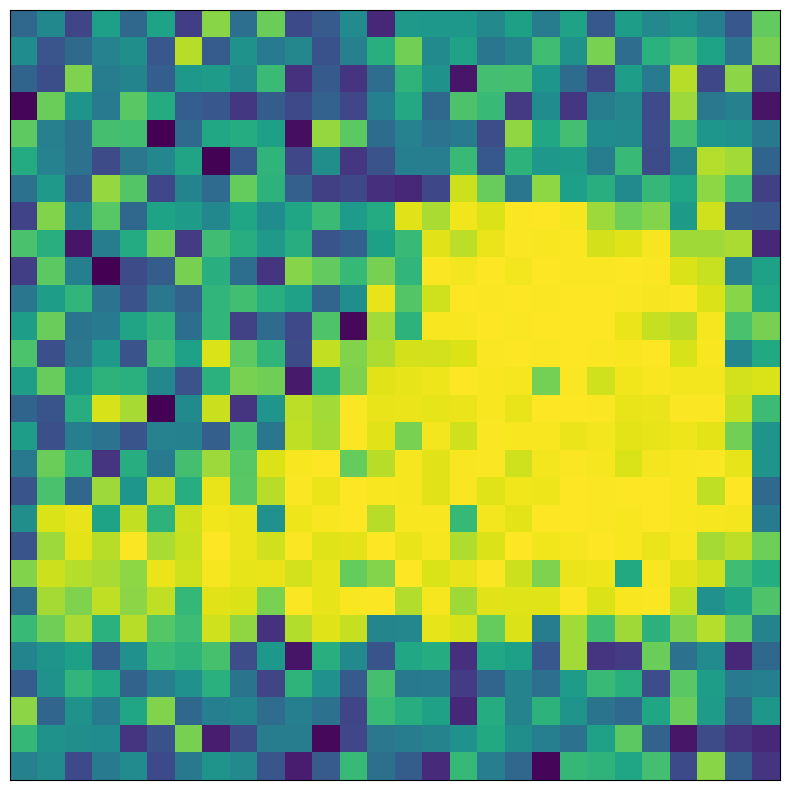

In [40]:
plt.figure(figsize=(10., 10.))

img_index = 1
plt.imshow(generated_imgs[img_index], cmap="viridis")

plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

plt.show()

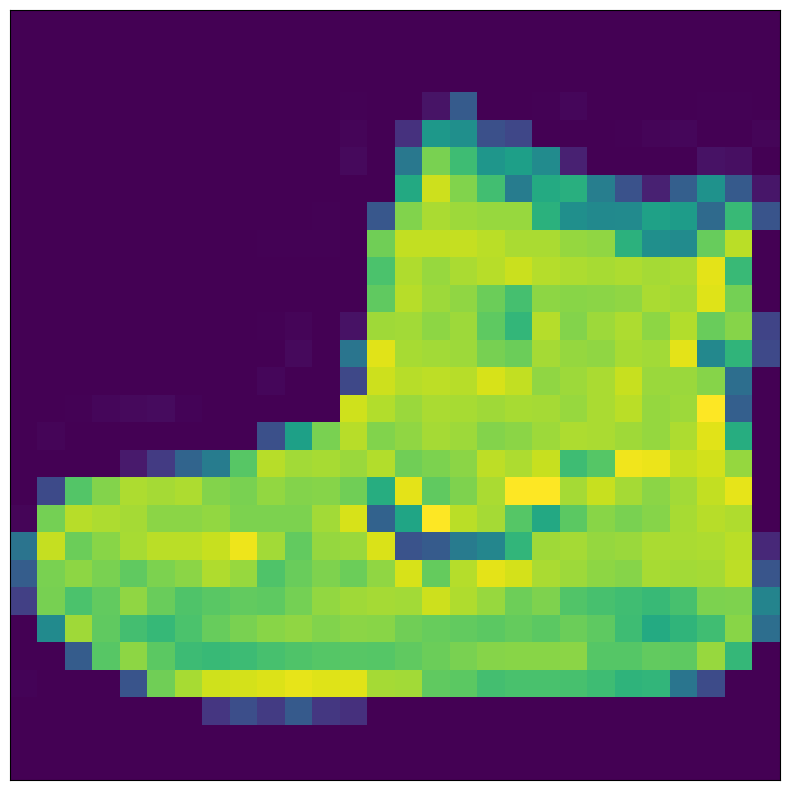

In [39]:
plt.figure(figsize=(10., 10.))

img_index = 0
plt.imshow(train_dataset[img_index][0].numpy().squeeze(), cmap="viridis")

plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])

plt.show()